In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR, VARMAX
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [4]:
df = pd.read_csv('train.csv', parse_dates=[0], index_col=0
                ,squeeze=True, date_parser=parser)

# Split training and validation set

In [5]:
train_start = pd.to_datetime('2010-03-01 00:00:00')
train_end = pd.to_datetime('2010-11-30 23:00:00')

train = df[train_start:train_end]
val = df[train_end:]

In [6]:
def plot1(train):
    figure, axis = plt.subplots(2,2, figsize=(48,24))

    axis[0,0].plot(train['deg_C'])
    axis[0,0,].set_title("Temperature", fontsize=48)

    axis[0,1].plot(train['relative_humidity'])
    axis[0,1,].set_title("Relative humidity", fontsize=48)

    axis[1,0].plot(train['absolute_humidity'])
    axis[1,0,].set_title("Absolute humidity", fontsize=48)

    axis[1,1].plot(train['sensor_1'])
    axis[1,1].set_title("Sensor 1", fontsize=48)
    
    plt.show()
    
def plot2(train) :
    figure, axis = plt.subplots(2,2, figsize=(48,24))
    
    axis[0,0].plot(train['sensor_2'])
    axis[0,0,].set_title("Sensor 2", fontsize=48)

    axis[0,1].plot(train['sensor_3'])
    axis[0,1,].set_title("Sensor 3", fontsize=48)

    axis[1,0].plot(train['sensor_4'])
    axis[1,0,].set_title("Sensor 4", fontsize=48)

    axis[1,1].plot(train['sensor_5'])
    axis[1,1].set_title("Sensor 5", fontsize=48)

    plt.show()

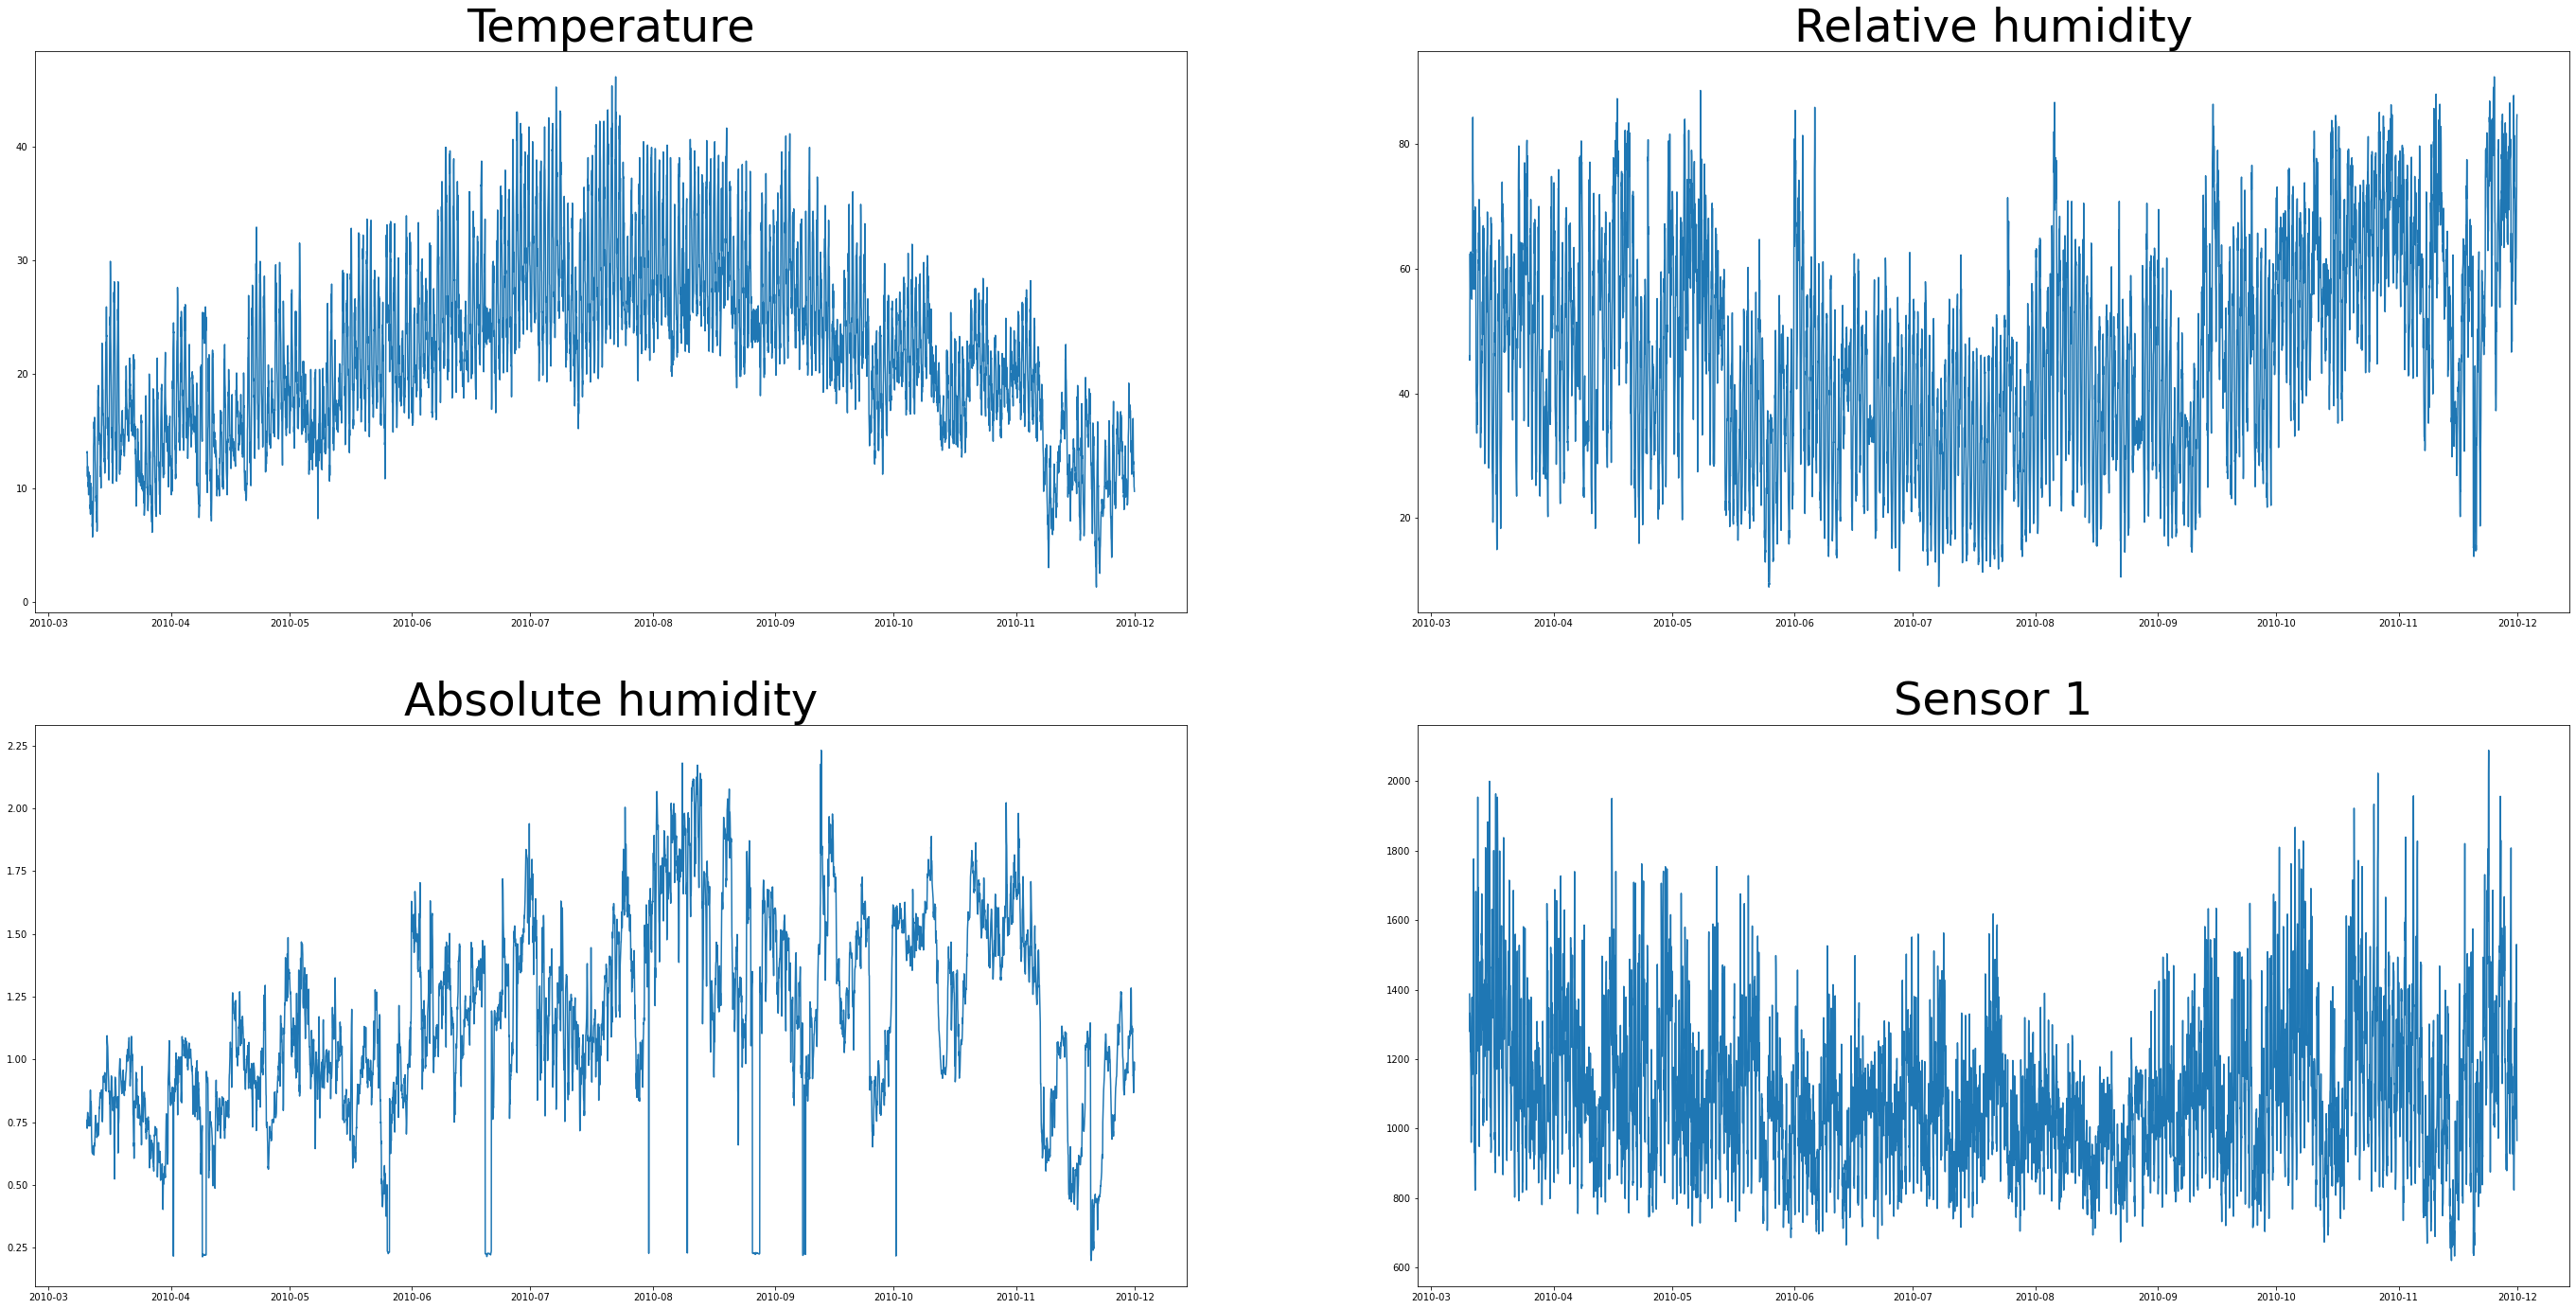

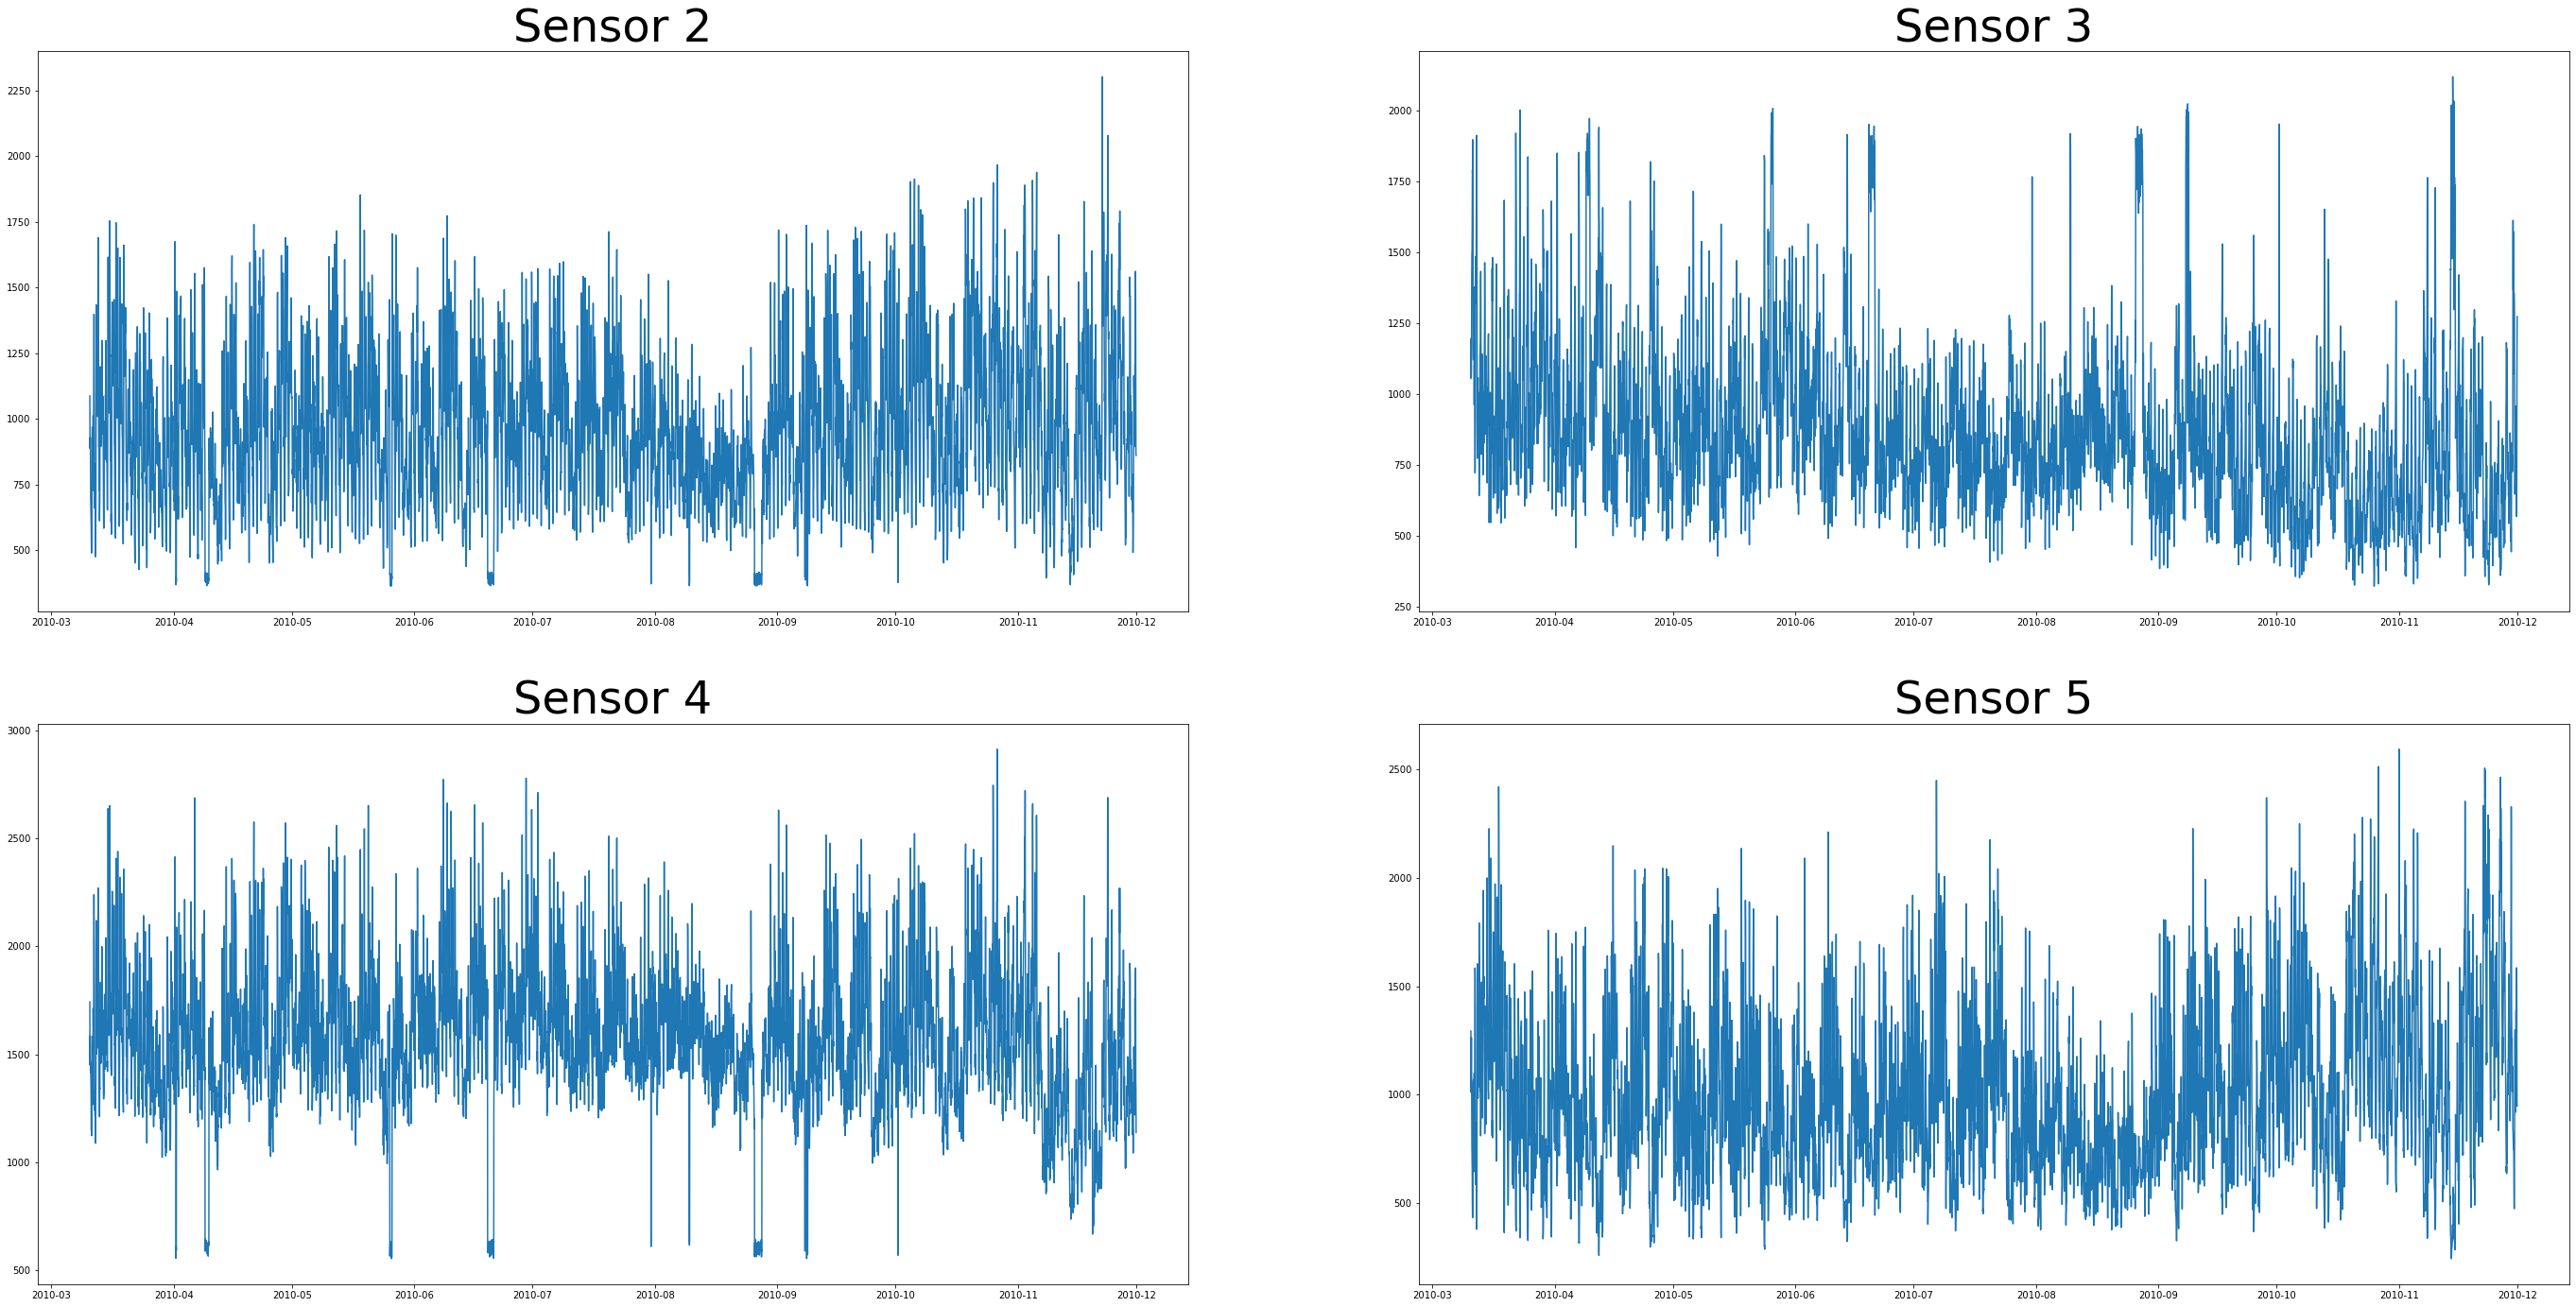

In [7]:
plot1(train)  
plot2(train)

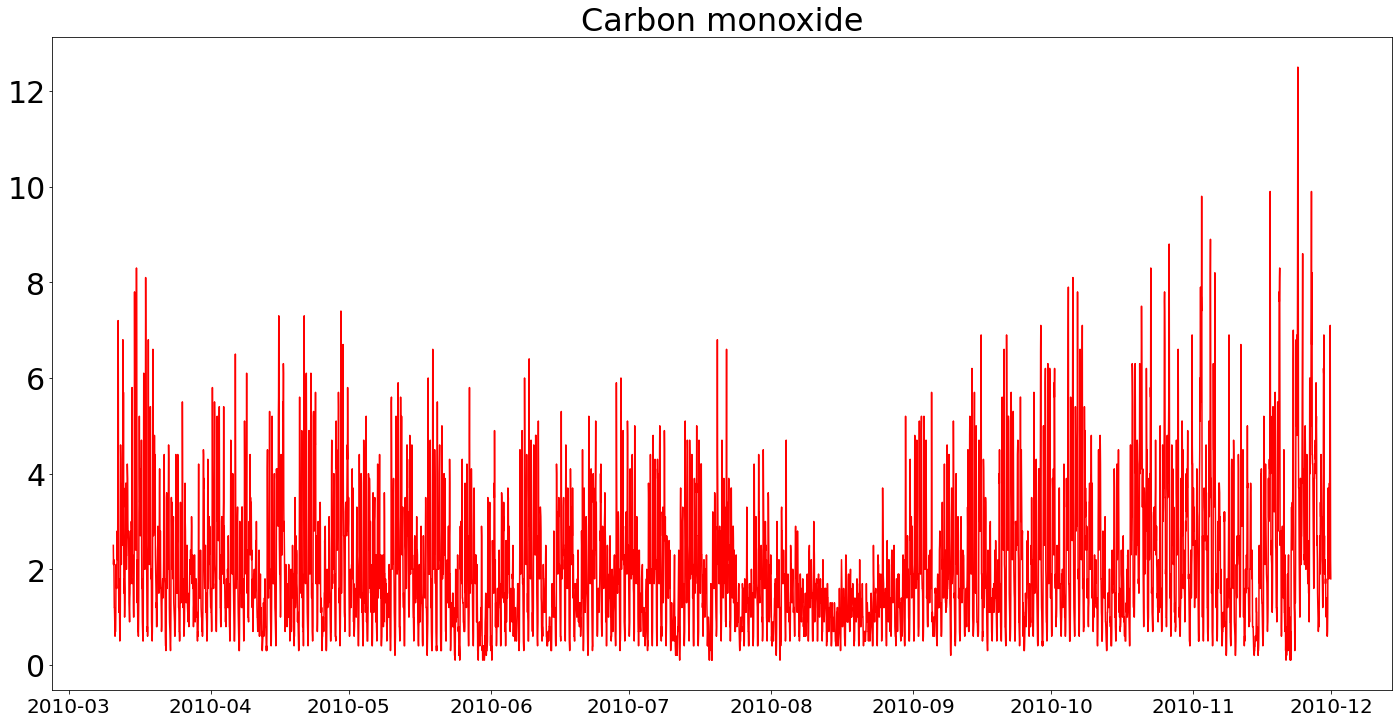

In [9]:
plt.figure(figsize=(24,12))
plt.title('Carbon monoxide', fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=30)
plt.plot(train['target_carbon_monoxide'], color='red')

In [10]:
# plt.figure(figsize=(24,12))
# plt.title('Benzene', fontsize=32)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=30)
# plt.plot(train['target_benzene'], color='orange')

In [11]:
# plt.figure(figsize=(24,12))
# plt.title('Nitrogen oxides', fontsize=32)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=30)
# plt.plot(train['target_nitrogen_oxides'], color='black')

# From the graphs, volatiliy is observed

# Remove trend by taking first difference

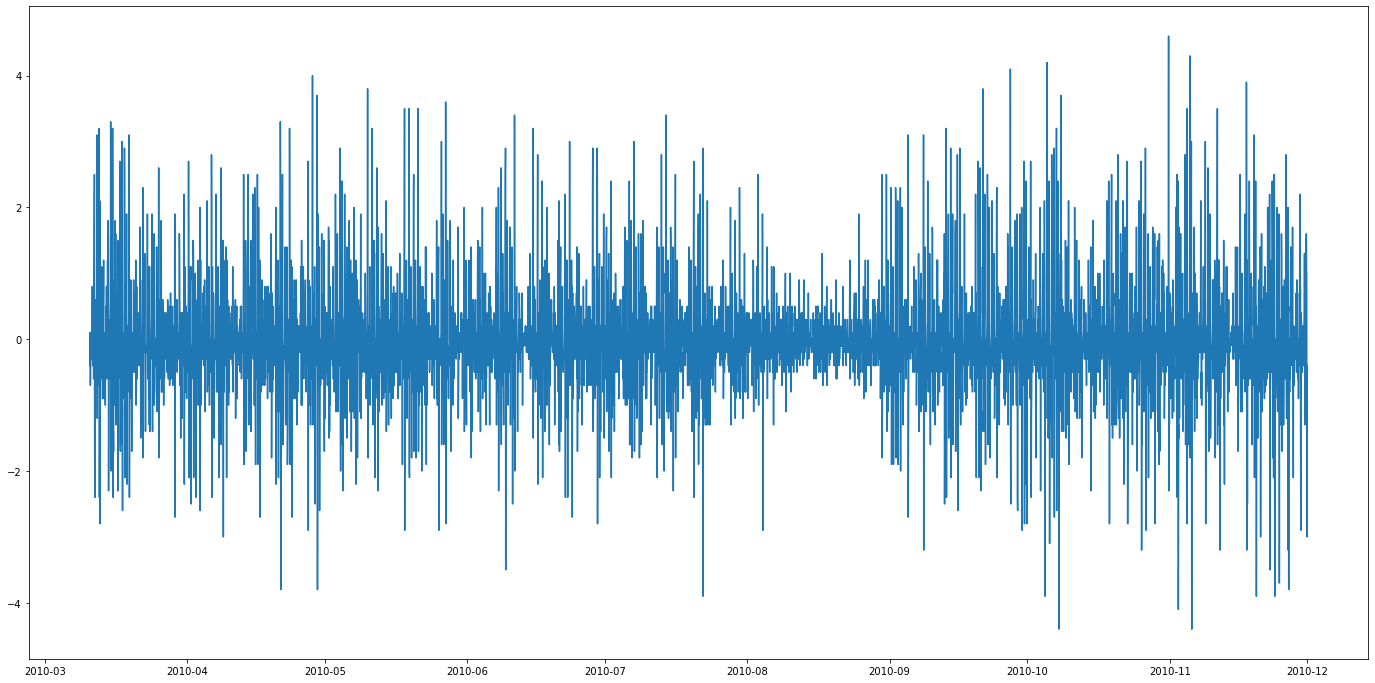

In [12]:
train_diff = train.diff().dropna()
train_diff = train_diff.asfreq(pd.infer_freq(train_diff.index))
plt.figure(figsize=(24,12))

plt.plot(train_diff['target_carbon_monoxide'])

# Normalise

In [13]:
train_diff_mean = train_diff.mean()
train_diff_sd = train_diff.std()

train_diff = (train_diff - train_diff_mean) / train_diff_sd

val_diff = val.diff().dropna()
val_diff = val_diff.asfreq(pd.infer_freq(val_diff.index))

val_diff_mean = val_diff.mean()
val_diff_std = val_diff.std()
val_diff = (val_diff-val_diff_mean) / val_diff_std

# Carbon monoxide

# test of stationarity

In [15]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [16]:
adf_test(train_diff['target_carbon_monoxide'])

ADF Statistic: -17.956003
p-value: 0.000000


In [17]:
# for column in train_diff.columns[:-3]:
#     adf_test(train_diff[column])

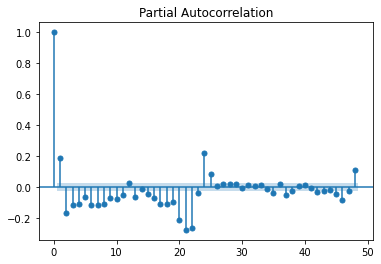

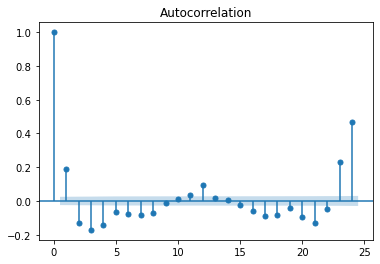

In [18]:
pacf = plot_pacf(train_diff['target_carbon_monoxide'], lags=48)
acf = plot_acf(train_diff['target_carbon_monoxide'], lags=24)

# stationarity is achieved with p<0.05

In [19]:
def modelsummary(df):
    df_model = VAR(df)

    df_model_fit = df_model.fit(29)
    print(df_model_fit.summary())

In [20]:
# modelsummary(train_diff)

# From summary (commented out due to length) and PACF plot, sensor 1-5 and lag=24 are significantly correlated to carbon monoxide quantity

# Rolling window forecast, VAR model

In [21]:
df_diff = train_diff.append(val_diff)
df_diff = df_diff.iloc[:, 3:9]

In [22]:
all_forecast = np.empty([len(val_diff.index), 6])

j=0
for i in val_diff.index:
    CO_variables = df_diff[:i]
    CO_variables_model = VAR(CO_variables)
    CO_variables_fit = CO_variables_model.fit(maxlags=24, ic='aic')
    lag_order = CO_variables_fit.k_ar
    
    forecast_1 = CO_variables_fit.forecast(CO_variables.values[-lag_order:], 1)
    all_forecast[j] = forecast_1
    j+=1
    
print('Training completed')

Training completed


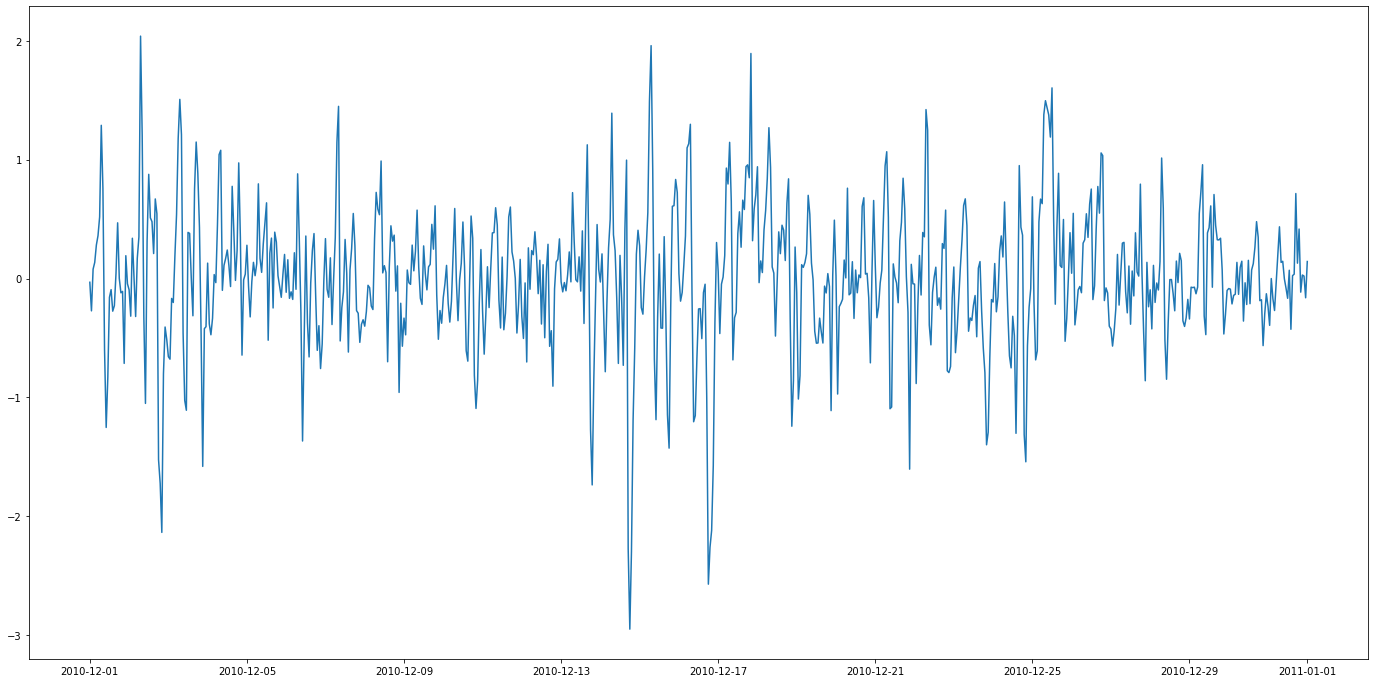

In [24]:
CO_forecast_norm = pd.DataFrame(all_forecast, columns = df_diff.columns, index = val_diff.index)
# CO_forecast = CO_forecast_norm
CO_forecast = CO_forecast_norm * train_diff_sd + train_diff_mean
CO_forecast = CO_forecast['target_carbon_monoxide']
plt.figure(figsize=(24,12))
plt.plot(CO_forecast)

# undo differencing

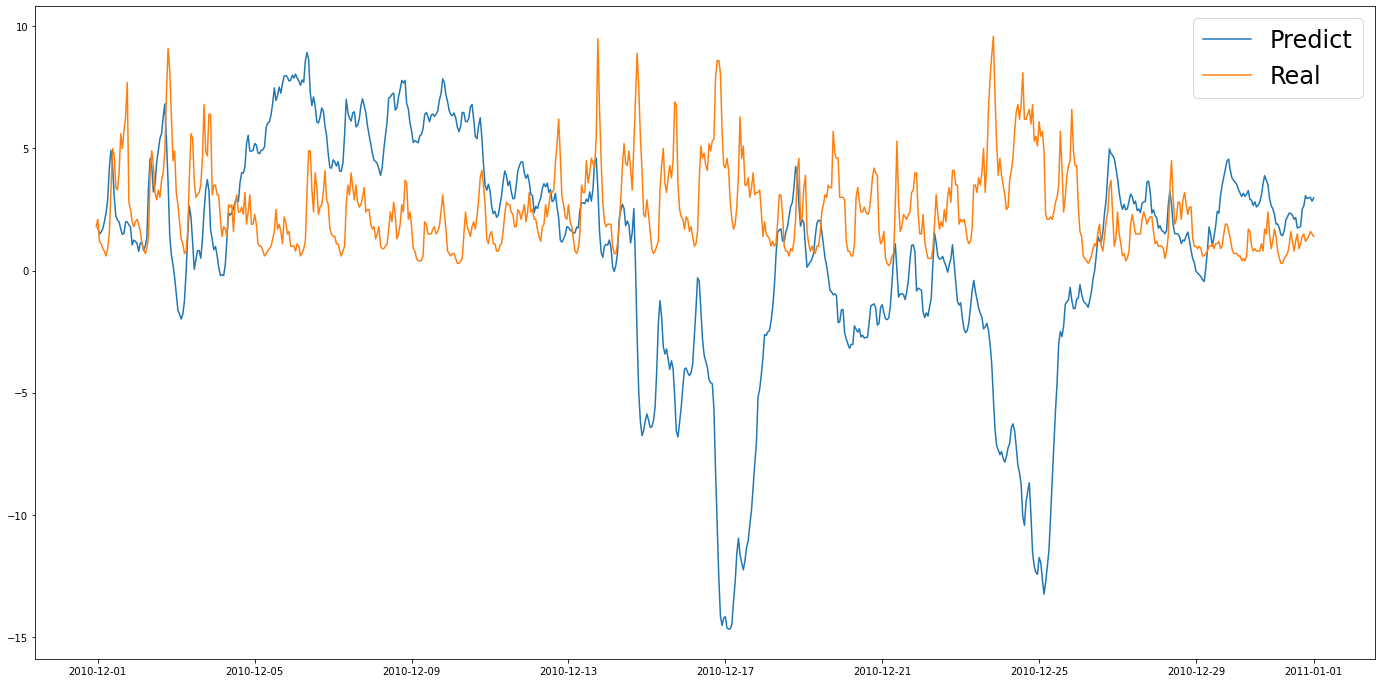

In [28]:
x, x_diff = val['target_carbon_monoxide'].iloc[0], CO_forecast
CO_forecast = np.r_[x, x_diff].cumsum().astype(float)

CO_forecast = pd.Series(CO_forecast[1:], index = val_diff.index)

plt.figure(figsize=(24,12))

plt.plot(CO_foreccast, label='Predict')
plt.plot(val['target_carbon_monoxide'], label='Real')
plt.legend(prop={'size': 24})

# residual of VAR model

In [31]:
residual = CO_foreccast - val['target_carbon_monoxide'].iloc[1:]
residual.mean()

-1.6790200690975798